**Import Library**

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**Kode Wilayah**

In [ ]:
kode_wilayah = "35.07.19.2001"

**Mengambil Data dari API BMKG**

In [ ]:
url = f"https://api.bmkg.go.id/publik/prakiraan-cuaca?adm4={kode_wilayah}"

response = requests.get(url)
data_json = response.json()

**Parsing Data Curah Hujan**

In [ ]:
data_list = []

for area in data_json['data']:
    for cuaca in area['cuaca']:
        for item in cuaca:
            data_list.append({
                'tanggal': item['local_datetime'],
                'curah_hujan': item.get('tp', 0)
            })

df = pd.DataFrame(data_list)
df['tanggal'] = pd.to_datetime(df['tanggal'])
df = df.sort_values('tanggal')

df.head()

,tanggal,curah_hujan
0,2025-12-18 10:00:00,0.0
1,2025-12-18 13:00:00,2.3
2,2025-12-18 16:00:00,0.0
3,2025-12-18 19:00:00,0.0
4,2025-12-18 22:00:00,0.0


**Preprocessing Time Series**

In [ ]:
data = df[['curah_hujan']].values

scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

**Membuat Dataset LSTM**

In [ ]:
def create_dataset(dataset, time_step=5):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 5
X, y = create_dataset(data_scaled, time_step)

**Split Data**

In [ ]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**Model LSTM**

In [ ]:
model = Sequential([
    LSTM(
        32,
        activation='tanh',
        recurrent_activation='sigmoid',
        input_shape=(time_step, 1)
    ),
    Dense(1, activation='linear')
])


model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - loss: 0.0420 - val_loss: 6.4078e-04
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0308 - val_loss: 5.5141e-04
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0291 - val_loss: 8.8211e-04
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0349 - val_loss: 0.0016
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0266 - val_loss: 0.0026
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0316 - val_loss: 0.0038
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0244 - val_loss: 0.0050
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0193 - val_loss: 0.0063
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0188 - val_loss: 0.0078
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0283 - val_loss: 0.0095
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0235 - val_loss: 0.0107
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0282 - val_l

**Prediksi & Inverse Scaling**

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


**Evaluasi**

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print("RMSE:", rmse)

RMSE: 0.17608540038441498


**Grafik Prediksi vs Aktual**

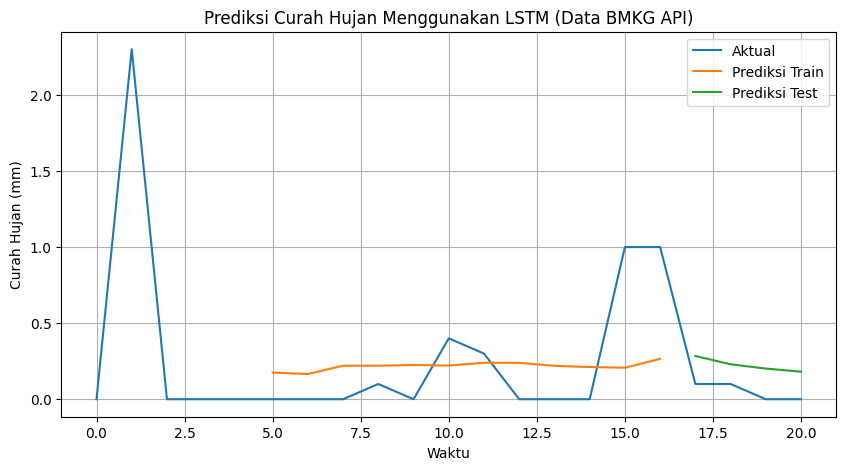

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['curah_hujan'].values, label='Aktual')

train_plot = np.empty_like(data)
train_plot[:] = np.nan
train_plot[time_step:train_size+time_step] = train_predict

test_plot = np.empty_like(data)
test_plot[:] = np.nan
test_plot[train_size+time_step:] = test_predict

plt.plot(train_plot, label='Prediksi Train')
plt.plot(test_plot, label='Prediksi Test')

plt.title('Prediksi Curah Hujan Menggunakan LSTM (Data BMKG API)')
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid()
plt.show()